In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [3]:
def lin_func(x,a):

    return x*a

# From: ".\Data\RIN_MHz\RIN measurements using HP detector.txt"
power_uW = np.array([581,580,578])
voltage_mV = np.array([161.89,161.61,161.13])

popt,pcov = curve_fit(lin_func,power_uW,voltage_mV)
conversion_factor = popt[0]
conversion_offset = 0

# plt.plot(power_uW,voltage_mV,'.')
# plt.plot(power_uW,lin_func(power_uW,popt[0]))
# plt.xlabel('Optical power [µW]')
# plt.ylabel('Voltage [mV]')

In [4]:
def get_paths_homodyne(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "homodyne" in e]

def get_paths_intensity(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if e.endswith("esa.txt")]#[directory + "\\" + e for e in filenames if e.endswith("esa.txt")][:-10]

def get_OSA_paths(directory):
    
    filenames = os.listdir(directory)
    return [directory + "\\" + e for e in filenames if "OSA" in e][:-10]


def get_data(path,length=1):

    return np.loadtxt(path, encoding = "unicode_escape",skiprows=1,delimiter=' ')

def plot_data(path,figure_no=1):

    header = get_header(path)[0]
    xs, ys = get_data(path)
    plt.figure(figure_no)
    plt.plot(xs*1e-9,ys)
    if len(header)>3:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}, {header[3]}')
    else:
        plt.title(f'{header[0]}, {header[1]}, {header[2]}')
    plt.xlabel('freq, f [GHz]')
    

def ratio_to_db(feedback_power,output_power,):

    if (feedback_power == 0.0) or (feedback_power == 0):
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)
    if (output_power == 0.0) or (output_power == 0):
        output_power = 0.000003

    return 10*np.log10(feedback_power/output_power)

def linear_to_dB(datapoint_linear):

    return 10*np.log10(datapoint_linear)


def dB_to_linear(power):
    pow_lin = 10**(power/10)
    return pow_lin

def OSA_fb_dB(feedback_power,peak_power,):

    peak_power_uW = 10**(peak_power/10)*1000 * 40 #in µW, multiplied by 40 to get correct value

    if feedback_power == 0.0:
        feedback_power = 0.000003 #0.003 nW (minimum for feedback PM)

    fb_dB = ratio_to_db(feedback_power,peak_power_uW)

    return fb_dB


def convert_optical_to_electrical(power, ret_V = False, conversion=371.7*1e-3/208): #Use power directly from PM (i.e. not multiplied by 40), and return average optical power squared in dBm


    # conversion = 371.7*1e-3/208 #V/µW      #307.4*1e-3/104.9 #V/µW      Conversion rate of PM power in µW to volts

    volts = conversion*power #V     Convert optical PM power to volts in ESA

    if ret_V:
        return volts
    
    else:

        elec_power = volts**2/50 #V^2/Ohm = W/Hz        Convert to electrical power

        elec_power_mW = 1e3*elec_power #mW/Hz           Make it mW

        power_sq_dBm = 10*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]       Take the average power, square it and make it into dBm

        return power_sq_dBm
        


def convert_optical_to_electrical2(power, ret_V = False, conversion=1.9/1950): #Use power directly from PM (i.e. not multiplied by 40), and return average optical power squared in dBm

    #power = 1020 #Same for all as it is the EDFA who determines this

    #conversion = 1.9/1950 #V/µW

    volts = conversion*power #V     Convert optical PM power to volts in ESA

    if ret_V:
        return volts
    
    else:

        elec_power = volts**2/50 #V^2/Ohm = W/Hz        Convert to electrical power

        elec_power_mW = 1e3*elec_power #mW/Hz           Make it mW

        power_sq_dBm = 10*np.log10(elec_power_mW/1) # 10*log10( [P/1mW]^2 ) [dBm]       Take the average power, square it and make it into dBm

        return power_sq_dBm



def get_header(path,length=1):
    lines = []
    with open(path,encoding="ISO-8859-1") as file:
        for i in range(length):
            line = file.readline()
            lines.append(line[1:].split(','))
    return lines


def esa_header_data(header):

    length = len(header[0])
    
    output_power = float(header[0][0].split(" ")[1][:-2])

    fb_level = float(header[0][1].split(" ")[3][:-2])
    
    if length == 6:
        gain = header[0][2][1:]

        pol = header[0][3].split(" ")[2]

        if 'MHz' in header[0][4].split(" ")[1]:
            rbw = float(header[0][4].split(" ")[1][4:-3])*1e6
        elif 'kHz' in header[0][4].split(" ")[1]:
            rbw = float(header[0][4].split(" ")[1][4:-3])*1e3
        else:
            rbw = float(header[0][4].split(" ")[1][4:-2])
        
    elif length == 5:
        pol = header[0][2].split(" ")[2]

        if 'MHz' in header[0][3].split(" ")[1]:
            rbw = float(header[0][3].split(" ")[1][4:-3])*1e6
        elif 'kHz' in header[0][3].split(" ")[1]:
            rbw = float(header[0][3].split(" ")[1][4:-3])*1e3
        else:
            rbw = float(header[0][3].split(" ")[1][4:-2])

        gain = 'None'

    if pol == 'Misaligned':
        pol = 'misaligned'

    if pol == 'Aligned':
        pol = 'aligned'

    if pol == 'None':
        pol='none'


    return output_power, fb_level, gain, pol, rbw


def scientific(x, pos):
    if x == 1e5:
        return r'$10^5$'
    elif x == 1e6:
        return r'$10^6$'
    elif x == 1e7:
        return r'$10^7$'
    else:
        return r'$%d \times 10^{%d}$' % (int(x / (10**int(np.log10(x)))), int(np.log10(x)))

In [5]:
def plot_intensity_data(directory): #For HP detector.

    paths = get_paths_intensity(directory)

    no_RIN_values = int(len(paths))

    single_RIN_values = [None for _ in range(no_RIN_values)]
    # fb_powers = [None for _ in range(no_RIN_values)]
    # polarizations = [None for _ in range(no_RIN_values)]
    

    fb_counter = [0,0,0,0,0,0,0,0]

    no_fb_rel_osc = [0,0,0,0,0,0]
    
    colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c','#f781bf', '#a65628', '#984ea3',
                  '#999999', '#dede00']


    # if "Digital impedance" in directory: #Due to wrong impedance matching digitally by ESA an offset is added
    #         imp_match = np.loadtxt(r".\Data\RIN_MHz\Background\Average_offset_imp_match.txt",skiprows=2)
    #         offset_imp = imp_match[0]

    for i, path in enumerate(paths):

        header = get_header(path,length=1)
        # print(header)

        power, fb_level, gain, pol, rbw = esa_header_data(header)

        

        xs, ys = get_data(path) #Hz, dBm

                    
                


        fb_level = 2*fb_level


        rbw_db = 10*np.log10(rbw) #Hz
        

        # fb_dB = ratio_to_db(fb_level,power)

        # power /= 40

        ys += -rbw_db #dBm/Hz   Remove raw data dependence on bandwidth 

        voltage_mV = conversion_factor*power + conversion_offset

        if '2025-04-30_17-53-11-876395esa' in path:
            voltage_mV = conversion_factor*580 #µW For background.


        ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]

        # print("divided with P_0^2", ys, any(np.isnan(ys)))

        # if "Digital impedance" in directory:
        #     ys -= offset_imp #To combat wrong digital conversion by ESA
        
        # if ((pol=='none') or (pol=='misaligned') or (pol=='aligned')): 
        #     plt.figure(0)
        #     plt.plot(xs,ys, label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
        # print(pol,fb_dB)
        # if pol == "misaligned" and abs(-7.5-fb_dB)<1:
        #     plt.figure(1)
        #     plt.plot(xs,ys, color = '#e41a1c', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 0.7)
        # elif pol == "aligned" and abs(-7.5-fb_dB)<1:
        #     plt.figure(1)
        #     plt.plot(xs,ys, color = '#4daf4a', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1)
        # elif pol == 'none' and power>0:
        #     plt.figure(1)
        #     plt.plot(xs,ys, color = '#377eb8', label = f'FB:{fb_dB:.1f}dB, {pol}',alpha = 1) # colors = ['#377eb8','#4daf4a','#ff7f00', '#e41a1c']

        plt.figure(0)
        plt.plot(xs,ys, alpha = 0.7)

        diff = xs[1]-xs[0]
        print(xs[10])
        single_RIN_values[i] = linear_to_dB( sum( dB_to_linear(ys[10:]) ) * diff ) #Hz, summing all the datapoints and multiplying with the difference in xs, converting to dB
        # fb_powers[i] = fb_dB
        # polarizations[i] = pol

    
    for i in range(0,2):#range(3)
        plt.figure(i)
        # plt.title(f'Fb at 110mA: {list_fb[i]} ')
        # plt.legend()
        if i ==0:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            # plt.ylim([-155,-110])
            plt.grid()
            plt.xlim([1e3,1e10])
        
        else:
            plt.xlabel('Frequency [Hz]')
            plt.xscale('log')
            plt.ylim([-147,-107])
            plt.xlim([1e3,1e7])
            plt.grid()

        plt.ylabel('RIN [dBc/Hz]')
        
        # plt.xlim([0,10])
        # plt.legend()
        plt.xscale('log')

        # save_path = r""

        if i==1:

            plt.legend(['No FB','Aligned -7.5 dB','Misaligned -7.5 dB'],loc=(0.5525,0.405),handletextpad=0.3,handlelength=0.95,fontsize=14)

            # plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz_HP.pdf',bbox_inches='tight')
            # plt.savefig(fr'{save_path}\\RIN_gain_fb_MHz_HP.png',bbox_inches='tight')

    return single_RIN_values #fb_powers, single_RIN_values, polarizations

1000000.0
1000000.0
1000000.0
1000000.0
1000000.0
1000000.0


C:\Users\au617810\AppData\Local\Temp\ipykernel_23568\4049893447.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  ys += -convert_optical_to_electrical2(power,conversion = voltage_mV*1e-3/power)#= 687e-3/220)#1.9/1950)  #Divide with the average optical power (in dB here, so subtract) [dBc/Hz]
C:\Users\au617810\AppData\Local\Temp\ipykernel_23568\3727259728.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  volts = conversion*power #V     Convert optical PM power to volts in ESA


[-33.74594502512383,
 -33.717480773874584,
 -33.717592213221124,
 -33.74005373363822,
 -33.76124483760289,
 nan]

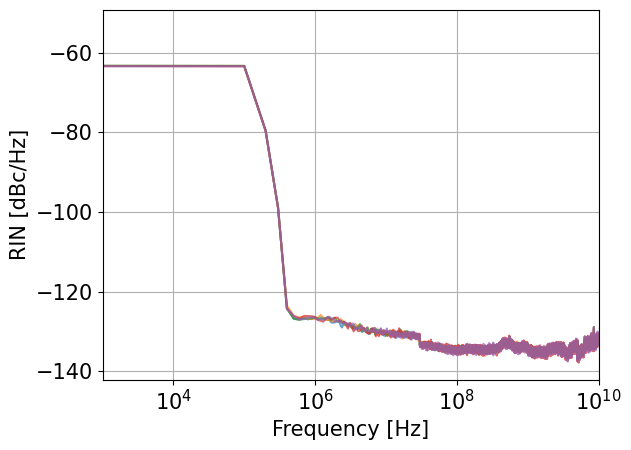

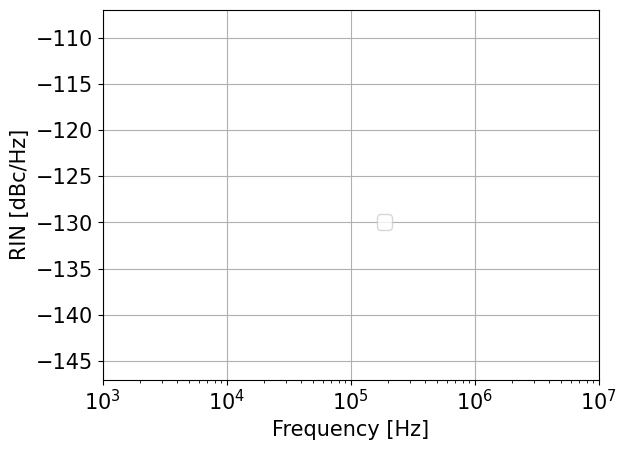

In [ ]:
plt.rcParams.update({'font.size': 15})

plot_intensity_data(